In [1]:
import pandas as pd
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
#Load data
data_path = "C:/Users/rajpu/Downloads/concert_tour_optimization_dataset.xlsx"
travel_costs_df = pd.read_excel(data_path, sheet_name='Travel Costs')
revenues_df = pd.read_excel(data_path, sheet_name='Revenues')

# Retrieve unique cities from the revenue DataFrame and generate a revenue dictionary and a cost matrix.
cities = revenues_df['City'].unique()
revenue_dict = revenues_df.set_index('City')['Revenue (USD)'].to_dict()
cost_matrix = pd.pivot_table(travel_costs_df, values='Cost (USD)', index='From', columns='To').fillna(0)
cost_matrix = cost_matrix.reindex(index=cities, columns=cities, fill_value=0)

# x[city]: Binary variable, 1 if city is visited, 0 otherwise.
# y[from_city, to_city]: Binary variable, 1 if traveling from 'from_city' to 'to_city', 0 otherwise.
x = {city: cp.Variable(boolean=True) for city in cities}
y = {(from_city, to_city): cp.Variable(boolean=True) for from_city in cities for to_city in cities}

# Maximize the total revenue from visiting cities minus a penalty for the travel costs between cities.
objective = cp.Maximize(sum(revenue_dict[city] * x[city] for city in cities) -
                        0.01 * sum(cost_matrix.at[from_city, to_city] * y[from_city, to_city] for from_city in cities for to_city in cities))

# Ensure that if a city is visited, there must be exactly one departure to another city and exactly one arrival from another city.
constraints = [
    sum(y[city, other] for other in cities if other != city) == x[city] for city in cities
]
constraints += [
    sum(y[other, city] for other in cities if other != city) == x[city] for city in cities
]

# Solve the initial problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Check for subtours and add constraints if necessary
y_vals = {(from_city, to_city): y[from_city, to_city].value for from_city in cities for to_city in cities}
subtours = find_subtours(y_vals)
while subtours:
    for subtour in subtours:
        constraints += [
            sum(y[subtour[i], subtour[(i + 1) % len(subtour)]] for i in range(len(subtour))) <= len(subtour) - 1
        ]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    y_vals = {(from_city, to_city): y[from_city, to_city].value for from_city in cities for to_city in cities}
    subtours = find_subtours(y_vals)

# Extract tour
tour_sequence = [(i, j) for (i, j), var in y_vals.items() if var > 0.9]
print("Tour sequence:", tour_sequence)
print("Maximum Revenue: $",problem.value)

Tour sequence: [('New York', 'Chicago'), ('Los Angeles', 'San Diego'), ('Chicago', 'San Jose'), ('Houston', 'Dallas'), ('Phoenix', 'San Antonio'), ('Philadelphia', 'New York'), ('San Antonio', 'Houston'), ('San Diego', 'Phoenix'), ('Dallas', 'Philadelphia'), ('San Jose', 'Los Angeles')]
Maximum Revenue: $ 157952.5


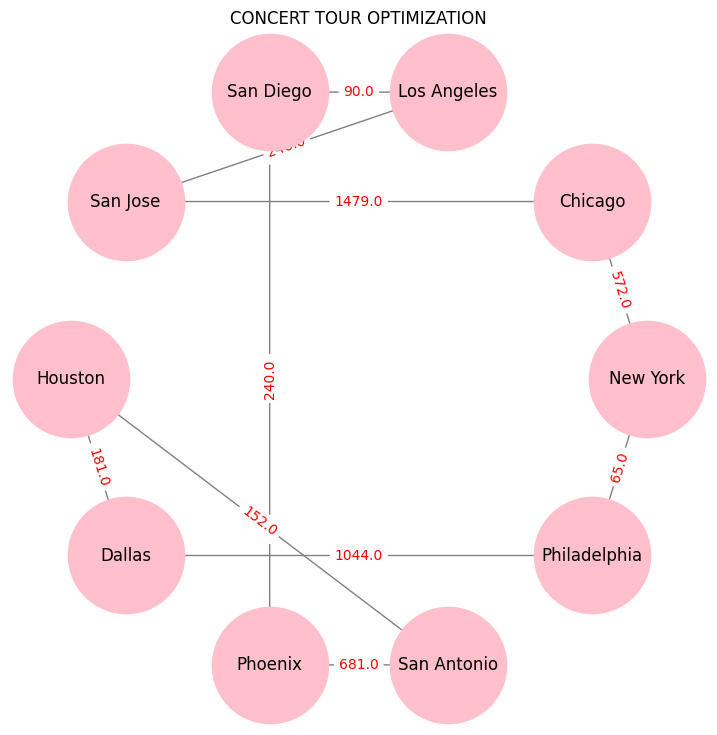

In [13]:
# Create the directed graph
G = nx.DiGraph()

for (from_city, to_city), var in y_vals.items():
    if var > 0.9:  
        weight = cost_matrix.at[from_city, to_city]
        G.add_edge(from_city, to_city, weight=weight)

# Customizing the graph layout for better visibility
pos = nx.circular_layout(G)  
fig, ax = plt.subplots(figsize=(9, 9)) 

# Draw the graph components
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='pink', ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color='gray', ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', font_color='black', ax=ax)

# Draw edge labels to show weights on the directed edges
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', ax=ax)

# Additional settings and display
plt.title("CONCERT TOUR OPTIMIZATION")
plt.axis('off')  # Turn off the axis to have a cleaner look
plt.show()
